In [226]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 
torch.manual_seed(1)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [227]:
num_features = 2
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

In [228]:
# Creating the artificial dataset
dim1_data = np.arange(0,5.2,0.1)
dim2_data = np.arange(0,0.52,0.01)

# dim1_data = np.linspace(0,3,52)
# dim2_data = np.linspace(0,0.3,52)

dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()

In [229]:
class Data2d(Dataset):   
    # Constructor
    def __init__(self):
        x_data = torch.tensor(dim1_data_scaled)
        y_data = torch.tensor(dim2_data_scaled)
        
        self.x = torch.zeros(len(dim1_data)-num_frames,input_size)
        self.x[:,3] = y_data[:-2]
        self.x[:,2] = x_data[:-2]
        self.x[:,1] = y_data[1:-1]
        self.x[:,0] = x_data[1:-1]
        
        self.y = torch.zeros(len(dim1_data)-num_frames,output_size)
        self.y[:,0] = x_data[2:]
        self.y[:,1] = y_data[2:]
        
        self.len = self.x.shape[0]
    
    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Getting the length
    def __len__(self):
        return self.len
# Instantiation of the class  
my_data = Data2d()

In [230]:
# Creating a linear regression model
class lin_reg(nn.Module):

    def __init__(self, in_feat, out_feat):
        super(lin_reg, self).__init__()
        self.linear = nn.Linear(in_feat, out_feat)
        
    def forward(self,x):
        yhat = self.linear(x)
        return yhat
    
# Instantiation of an object
model = lin_reg(input_size,output_size)
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict([('linear.weight', tensor([[ 0.2576, -0.2207, -0.0969,  0.2347],
        [-0.4707,  0.2999, -0.1029,  0.2544]])), ('linear.bias', tensor([ 0.0695, -0.0612]))])


In [231]:
# Parameters
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01) 
# Training data object which loads the artificial data
trainloader = DataLoader(dataset = my_data, batch_size = 1)
# Training the model
Loss = []  # variable for storing losses after each epoch
epochs = 50

def train_model(epochs):
    for epoch in range(epochs):
        for x,y in trainloader:
            yhat = model(x)
            loss = criterion(yhat,y)
            Loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
# Calling the training function          
train_model(epochs)

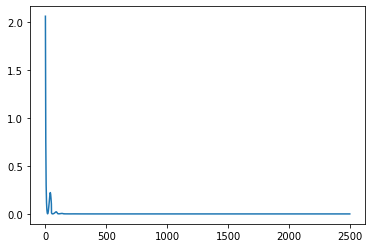

In [232]:
plt.plot(Loss)

In [236]:
query_dim1 = np.array([6.2,6.1])
query_dim2 = np.array([0.62,0.61])
print(query_dim1)
print(query_dim2)

scaled_query_dim1 = (query_dim1 - dim1_data.mean())/dim1_data.std()
scaled_query_dim2 = (query_dim2 - dim2_data.mean())/dim2_data.std()
print(scaled_query_dim1)
print(scaled_query_dim2)

# Build combination so x and y are adjacent for 1 pose
c = np.empty(scaled_query_dim1.size + scaled_query_dim2.size)
c[0::2] = scaled_query_dim1
c[1::2] = scaled_query_dim2

new_query = Variable(torch.Tensor([c]))
print(new_query)

answer = model(new_query)
print('\n raw answer:\n',answer)
print('\n scaled up again:\n')
print(answer[0][0]*dim1_data.std() + dim1_data.mean())
print(answer[0][1]*dim2_data.std() + dim2_data.mean())

[6.2 6.1]
[0.62 0.61]
[2.43198261 2.36535295]
[2.43198261 2.36535295]
tensor([[2.4320, 2.4320, 2.3654, 2.3654]])

 raw answer:
 tensor([[2.4986, 2.4986]], grad_fn=<AddmmBackward>)

 scaled up again:

tensor(6.3000, grad_fn=<AddBackward0>)
tensor(0.6300, grad_fn=<AddBackward0>)
